# Case Study: Borden

The Borden dataset is a simple, low-resource DEM that forms the basis of the
Borden Benchmark test case.

The test case is based on the original field experiment and hydraulic parameters of
[Abdul and Gillham](https://doi.org/10.1016/0022-1694(89)90177-7), and is used by
[Kollet et al.](https://doi.org/10.1002/2016WR019191) for integrated hydrologic
model intercomparison.

In [1]:
import tinerator as tin

data = tin.ExampleData.Borden

## Borden DEMs

The DEM is available in both 1 meter and 0.5 meter (50 cm) resolutions:

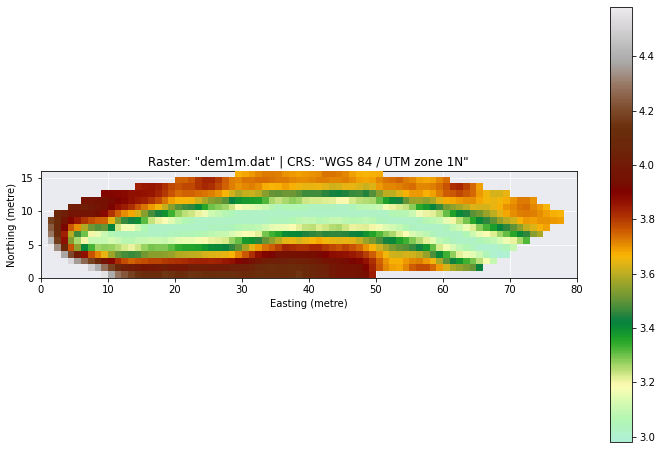

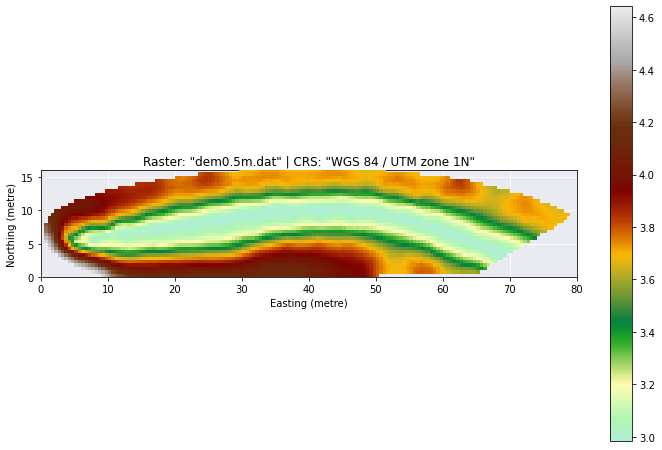

In [2]:
dem_1m = tin.gis.load_raster(data.dem_1m)
dem_1m.fill_depressions()

dem_50cm = tin.gis.load_raster(data.dem_50cm)
dem_50cm.fill_depressions()

dem_1m.plot()
dem_50cm.plot()

## Generating the surface mesh

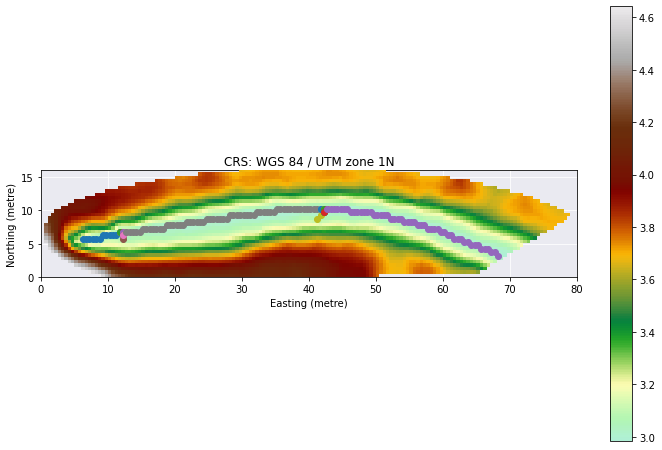

In [3]:
ws_flow = tin.gis.watershed_delineation(dem_50cm, threshold=100., method='D8')
ws_flow.plot(layers=[dem_50cm])

In [4]:
triangular_surface = tin.meshing.triangulate(
    dem_50cm,
    min_edge_length=0.01,
    max_edge_length=0.1,
    method='jigsaw',
    refinement_feature=ws_flow,
    scaling_type='relative',
)

triangular_surface.view(window_size=(400,400))

# Extruding the mesh

The layering schema is:
  * Layer 1: 50 cm thick, with 5 sublayers
  * Layer 2: 1 meter thick, with 5 sublayers in 20 cm increments
  * Layer 3: flat bottom at `z = 0 m`, with 5 sublayers

In [5]:
layers = [
    ("constant", 0.5, 5, 1),
    ("constant", 1., 5, 2),
    ("snapped", 0., 5, 3),
]

volume_mesh = tin.meshing.extrude_mesh(triangular_surface, layers)
volume_mesh.view(window_size=(800,800))

# Generating sets

To generate sets, we first build a surface mesh with `vol_mesh.surface_mesh()`. This provides us with the necessarily helper functions to get started constructing side and point sets.

Some default sets are available, like `top_faces`, `top_nodes`, `bottom_faces`, `bottom_nodes`, `side_faces`, and `side_nodes`.

We can pass these sets into the `vol_mesh.view()` method to see them.

In [6]:
# Extract the surface mesh
surface_mesh = volume_mesh.surface_mesh()
surface_mesh.view()

In [8]:
# Extract top and bottom faces, and side nodes
top_faces = surface_mesh.top_faces
bottom_faces = surface_mesh.bottom_faces
side_faces = surface_mesh.side_faces

print('Sets')
print('----')
print(top_faces)
print(bottom_faces)
print(side_faces)

# View them
volume_mesh.view(sets=(top_faces, bottom_faces, side_faces), window_size=(800, 800))

Sets
----
SideSet<name=TopFaces, num_faces=2286>
SideSet<name=BottomFaces, num_faces=2286>
SideSet<name=SideFaces, num_faces=1320>


# Advanced set operations

More advanced set functionality is provided. With the `discretize_sides` method, we can pass in a set of nodes (in clockwise ordering) to capture the faces along that perimeter. The nodes are (x, y) pairs, assumed to be in the same CRS as the mesh.

Using the `at_layer` argument allows you to specify a specific layer instead of every side.

There are also set functions like `remove`, `join`, and `intersection`, which allow you to interact with sets for more complex generation.

In [13]:
# Generates two sets:
#  1 - Outlet (between the line segment in `outlet_pts`)
#  2 - No flow (everywhere else)

outlet_pts = [
    (71.9, 4.7),
    (67.3, 2.1),
]

# Returns list of two sets
outlet = surface_mesh.discretize_sides(
    outlet_pts, close_ends=True, #at_layer=(1, 1), set_name_prefix="Outlet"
)

# Change the set names
outlet[0].name = "Outlet"
outlet[1].name = "NoFlow"

print('Outlet sets: ')
print('-------------')
print(outlet)

# Visualize
volume_mesh.view(sets=[outlet])

Outlet sets: 
-------------
[SideSet<name=Outlet, num_faces=90>, SideSet<name=NoFlow, num_faces=1230>]


# Writing to disk

Sets can be written to disk in the ExodusII meshing format:

In [15]:
volume_mesh.save("Borden.exo", sets=[outlet, top_faces, bottom_faces])

Outlet: min = 700; max = 33997
NoFlow: min = 11; max = 34268
TopFaces: min = 1; max = 2286
BottomFaces: min = 32005; max = 34290

You are using exodus.py v 1.20.2 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: Borden.exo
Closing exodus file: Borden.exo
EXODUS write was successful.
